In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def calcular_angulos_torso_cuat(rot_torso, R_SB_torso): 
    """Calcula los ángulos de flexión/extensión, abducción/aducción y rotación interna/externa del torso."""
    angulos_torso = []
    
    # Desde ENU to local frames
    torso_local = transformar_rotacion(rot_torso, R_SB_torso)
    
    for i in range(len(torso_local)):  # Se itera a través de los índices
        R_torso = torso_local[i]

        # Tilt (flexión/extensión) - rotación alrededor de Y
        tilt = np.degrees(np.arctan2(R_torso[2, 0], R_torso[0, 0]))

        # Obliquity (inclinación lateral) - rotación alrededor de X
        obliquity = np.degrees(np.arctan2(R_torso[1, 0], R_torso[0, 0]))

        # Rotation (axial) - reemplazado por cuaterniones
        q = rot_torso[i]
        if q.shape[0] == 4:
            q_scipy = np.array([q[1], q[2], q[3], q[0]])  # [w, x, y, z] → [x, y, z, w]
        else:
            q_scipy = q  # ya en formato [x, y, z, w]

        R_global = R.from_quat(q_scipy).as_matrix()
        R_local = R_SB_torso @ R_global
        z_axis = R_local[:, 2]
        x, y = z_axis[0], z_axis[1]
        rotation = np.degrees(np.arctan2(y, x))

        angulos_torso.append([tilt, obliquity, rotation])
        
    angulos_torso = np.array(angulos_torso)

    # Centrar los ángulos en 0
    angulos_torso -= angulos_torso[0]

    return angulos_torso


In [30]:
def quaternion_multiply(p, q):
    """ Multiplica dos cuaterniones dados en formato (q4, q1, q2, q3). """
    p4, p1, p2, p3 = p
    q4, q1, q2, q3 = q

    # Parte escalar
    real_part = p4 * q4 - (p1 * q1 + p2 * q2 + p3 * q3)

    # Parte vectorial
    vector_part = np.array([
        p4 * q1 + q4 * p1 + (p2 * q3 - p3 * q2),  # q1
        p4 * q2 + q4 * p2 + (p3 * q1 - p1 * q3),  # q2
        p4 * q3 + q4 * p3 + (p1 * q2 - p2 * q1)   # q3
    ])

    return np.hstack([real_part, vector_part])

def rotate_quaternion_180_x(q_sensor):
    """Rota un cuaternión 180° alrededor del eje X."""
    q_rot = np.array([0, 1, 0, 0])  # Rotación de 180° en X
    q_rot_conj = np.array([0, -1, 0, 0])  # Conjugado de q_rot
    q_temp = quaternion_multiply(q_rot, q_sensor)
    return quaternion_multiply(q_temp, q_rot_conj)

In [22]:
# Ejemplo de cuaternión del sensor (w, x, y, z)
q_sensor = np.array([0.60651821, 0.3082135, -0.65303624, 0.332692])  # Cuaternión de ejemplo

q_rotated = rotate_quaternion_180_x(q_sensor)
print("Cuaternión rotado:", q_rotated)

Cuaternión rotado: [ 0.60651821  0.3082135   0.65303624 -0.332692  ]


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def quaternion_to_rotation_matrix(q):
    """Convierte un cuaternión (w, x, y, z) a una matriz de rotación 3x3, asegurando el orden correcto."""
    return R.from_quat([q[1], q[2], q[3], q[0]]).as_matrix()  # SciPy usa (x, y, z, w)

def rotation_matrix_to_quaternion(R_matrix):
    """Convierte una matriz de rotación 3x3 a un cuaternión (w, x, y, z) respetando el orden correcto."""
    q = R.from_matrix(R_matrix).as_quat()  # SciPy devuelve (x, y, z, w)
    return np.array([q[3], q[0], q[1], q[2]])  # Convertimos a (w, x, y, z)

def rotate_quaternion_180_x(q_sensor):
    """Rota un cuaternión 180° en el eje X usando matrices de rotación."""
    R_x_180 = np.array([[1,  0,  0],
                         [0, -1,  0],
                         [0,  0, -1]])
    
    R_sensor = quaternion_to_rotation_matrix(q_sensor)
    R_rotated = R_x_180 @ R_sensor  # Multiplicación de matrices
    q_rotated = rotation_matrix_to_quaternion(R_rotated)
    
    return q_rotated

# 📌 Cuaternión de prueba (w, x, y, z)
q_sensor = np.array([0.60651821, 0.3082135, -0.65303624, 0.332692])

# Aplicamos la rotación
q_rotated = rotate_quaternion_180_x(q_sensor)
print("Cuaternión rotado:", q_rotated)

# 📌 Verificamos la rotación inversa (debería regresar al original)
q_reversed = rotate_quaternion_180_x(q_rotated)
print("Cuaternión después de rotar de nuevo:", q_reversed)

# 🔍 Verificación con el producto punto
dot_product = np.dot(q_sensor, q_reversed)
print("Producto punto entre q_sensor y q_reversed:", dot_product)

# Comparar si están representando la misma orientación (valor cercano a ±1)
if np.allclose(q_sensor, q_reversed, atol=1e-6) or np.allclose(q_sensor, -q_reversed, atol=1e-6):
    print("✅ La rotación de 180° en X funciona correctamente (se mantiene la orientación esperada).")
else:
    print("❌ Algo está mal con la transformación.")

Cuaternión rotado: [ 0.30821347 -0.60651815  0.33269197  0.65303618]
Cuaternión después de rotar de nuevo: [-0.60651815 -0.30821347  0.65303618 -0.33269197]
Producto punto entre q_sensor y q_reversed: -1.0000000991305908
✅ La rotación de 180° en X funciona correctamente (se mantiene la orientación esperada).


In [ ]:

import numpy as np

def leer_cuaterniones_desde_csv(ruta_csv, nombre_columna_qw, nombre_columna_qx, nombre_columna_qy, nombre_columna_qz):
    """
    Lee las columnas de cuaterniones desde un archivo CSV.

    Args:
        ruta_csv (str): Ruta al archivo CSV.
        nombre_columna_qw (str): Nombre de la columna para la parte real del cuaternión (qw).
        nombre_columna_qx (str): Nombre de la columna para la componente i del cuaternión (qx).
        nombre_columna_qy (str): Nombre de la columna para la componente j del cuaternión (qy).
        nombre_columna_qz (str): Nombre de la columna para la componente k del cuaternión (qz).

    Returns:
        numpy.ndarray: Un array de NumPy con los cuaterniones.
    """

    try:
        df = pd.read_csv(ruta_csv)

        # Verifica si las columnas existen
        if not all(col in df.columns for col in [nombre_columna_qw, nombre_columna_qx, nombre_columna_qy, nombre_columna_qz]):
            raise ValueError("Una o más columnas de cuaterniones no se encontraron en el archivo CSV.")

        # Extrae las columnas de cuaterniones y crea un array de NumPy
        cuaterniones = df[[nombre_columna_qw, nombre_columna_qx, nombre_columna_qy, nombre_columna_qz]].to_numpy()

        return cuaterniones

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo CSV en la ruta: {ruta_csv}")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")
        return None

# Ejemplo de uso
ruta_archivo_csv = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\GitHub\IMU-3D-Kinematics\data\24.02.2025\XSENS\XSENS CUATERNIONES\133310\muslo_der_val_D422CD002A96_20250224_133310.csv'  # Reemplaza con la ruta de tu archivo CSV
nombre_columna_qw = 'Quat_W'
nombre_columna_qx = 'Quat_X'
nombre_columna_qy = 'Quat_Y'
nombre_columna_qz = 'Quat_Z'

cuaterniones_leidos = leer_cuaterniones_desde_csv(ruta_archivo_csv, nombre_columna_qw, nombre_columna_qx, nombre_columna_qy, nombre_columna_qz)

if cuaterniones_leidos is not None:
    print("Cuaterniones leídos desde el archivo CSV:")
    print(cuaterniones_leidos)

Cuaterniones leídos desde el archivo CSV:
[[ 0.60651821  0.3082135  -0.65303624  0.332692  ]
 [ 0.60645962  0.30831042 -0.65302116  0.33273879]
 [ 0.60643244  0.30834597 -0.65300655  0.33278373]
 ...
 [ 0.65094727  0.23348083 -0.68244565  0.2366859 ]
 [ 0.6509335   0.23342748 -0.68247765  0.23668417]
 [ 0.65090144  0.23341578 -0.68249923  0.23672129]]


In [11]:
def cuaterniones_a_rotacion(qw, qx, qy, qz):
    q = np.array([qw, qx, qy, qz])
    r = R.from_quat(q)
    return r.as_matrix()


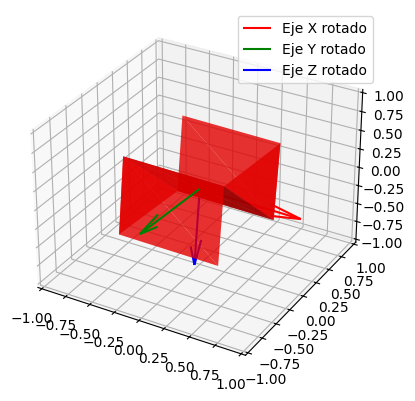

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def graficar_cubo_con_ejes_rotados(matriz_rotacion):
    """Grafica un cubo con sus ejes rotados por la matriz de rotación."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ejes originales
    ejes_originales = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    # Aplicar rotación a los ejes
    ejes_rotados = matriz_rotacion @ ejes_originales.T

    # Vértices de un cubo
    vertices = np.array([
        [-0.5, -0.5, -0.5],
        [0.5, -0.5, -0.5],
        [0.5, 0.5, -0.5],
        [-0.5, 0.5, -0.5],
        [-0.5, -0.5, 0.5],
        [0.5, -0.5, 0.5],
        [0.5, 0.5, 0.5],
        [-0.5, 0.5, 0.5]
    ])
    # Aplicar rotación a los vértices
    vertices_rotados = (matriz_rotacion @ vertices.T).T

    # Graficar el cubo rotado
    ax.plot_trisurf(vertices_rotados[:, 0], vertices_rotados[:, 1], vertices_rotados[:, 2], color='red', alpha=0.8)

    # Graficar los ejes rotados
    ax.quiver(0, 0, 0, ejes_rotados[0, 0], ejes_rotados[1, 0], ejes_rotados[2, 0], color='r', label='Eje X rotado')
    ax.quiver(0, 0, 0, ejes_rotados[0, 1], ejes_rotados[1, 1], ejes_rotados[2, 1], color='g', label='Eje Y rotado')
    ax.quiver(0, 0, 0, ejes_rotados[0, 2], ejes_rotados[1, 2], ejes_rotados[2, 2], color='b', label='Eje Z rotado')

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.legend()
    plt.show()

# Cuaternión proporcionado
cuaternion = [0.9992160201072693, -0.002549511380493641, -0.004998235031962395, 0.03919104114174843]

# Convertir cuaternión a matriz de rotación
rotacion = R.from_quat(cuaternion)
matriz_rotacion = rotacion.as_matrix()

# Graficar la matriz de rotación
graficar_cubo_con_ejes_rotados(matriz_rotacion)

In [1]:
import numpy as np

# Ejemplo de matrices de rotación (suponiendo que vienen de sensores inerciales)
R_pelvis = np.array([[0.866, -0.5, 0],  # Matriz de rotación de la pelvis
                      [0.5, 0.866, 0],
                      [0, 0, 1]])

R_muslo = np.array([[0.707, -0.707, 0],  # Matriz de rotación del muslo
                     [0.707, 0.707, 0],
                     [0, 0, 1]])

# Cálculo de la rotación relativa muslo-pelvis
R_muslo_pelvis = np.dot(R_pelvis.T, R_muslo)

print("Matriz de rotación relativa (muslo respecto a pelvis):")
print(R_muslo_pelvis)


Matriz de rotación relativa (muslo respecto a pelvis):
[[ 0.965762 -0.258762  0.      ]
 [ 0.258762  0.965762  0.      ]
 [ 0.        0.        1.      ]]
